In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

## Custom Dataset Class

We define a custom `WasteDataset` class that inherits from PyTorch's `Dataset` class. This class is responsible for loading and preprocessing the images from the dataset.

### Initialization

The `__init__` method takes the following parameters:
- `root_dir`: The root directory containing the dataset images.
- `split`: The dataset split (train, validation, or test).
- `transform`: Optional image transformations to be applied.

Inside the `__init__` method, we:
1. Store the `root_dir`, `transform`, and `split` parameters.
2. Get the list of class names by listing the directories in `root_dir`.
3. Initialize empty lists for `image_paths` and `labels`.
4. Iterate over each class directory and its subfolders ('default' and 'real_world').
5. Shuffle the image names in each subfolder.
6. Based on the `split` parameter, select a portion of the images (60% for train, 20% for validation, 20% for test).
7. Append the image paths and corresponding labels to the respective lists.

### Length and Item Retrieval

The `__len__` method returns the total number of images in the dataset.

The `__getitem__` method takes an `index` and returns the image and its corresponding label at that index. It:
1. Retrieves the image path and label using the provided index.
2. Opens the image using `Image.open()` and converts it to RGB format.
3. Applies the specified image transformations, if any.
4. Returns the transformed image and its label.

This custom dataset class allows us to easily load and preprocess the waste images for training, validation, and testing.

In [2]:
# Define the dataset class (modified to include a split parameter)
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['aluminum_can','paper_meal_box','paper_cup','plastic_bottle'] #sorted(os.listdir(root_dir)) 
        self.image_paths = []
        self.labels = []
        
        for i, class_name in enumerate(self.classes):
                class_dir = os.path.join(root_dir, class_name)
                image_names = os.listdir(class_dir)
                random.shuffle(image_names)
                
                if split == 'train':
                    image_names = image_names[:int(0.6 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.6 * len(image_names)):int(0.8 * len(image_names))]
                else:  # split == 'test'
                    image_names = image_names[int(0.8 * len(image_names)):]
                
                for image_name in image_names:
                    self.image_paths.append(os.path.join(class_dir, image_name))
                    self.labels.append(i)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

## Dataset Path and Hyperparameters

We set the following dataset path and hyperparameters:
- `dataset_path`: The path to the directory containing the dataset images.
- `batch_size`: The number of samples per batch during training and evaluation.
- `num_epochs`: The number of epochs to train the model.
- `learning_rate`: The learning rate for the optimizer.

These hyperparameters can be adjusted based on the specific requirements and available computational resources.

In [3]:
# Set the dataset path and hyperparameters
dataset_path = 'clean_dataset'
batch_size = 32
num_epochs = 10
learning_rate = 0.001

## Data Preprocessing and Loaders

We define a composition of image transformations using `transforms.Compose`:
1. `transforms.Resize((224, 224))`: Resizes the images to a fixed size of (224, 224) pixels.
2. `transforms.ToTensor()`: Converts the images to PyTorch tensors.
3. `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Normalizes the image tensors using the specified mean and standard deviation values.

These transformations ensure that the images are preprocessed consistently before being fed into the model.

We create instances of the `WasteDataset` class for the train, validation, and test splits, passing the `dataset_path`, `split`, and `transform` parameters. This allows us to load the dataset images with the specified transformations for each split.

Finally, we create data loaders for each dataset using `DataLoader`:
- `train_dataloader`: Loads the training data in batches of size `batch_size` and shuffles the samples.
- `val_dataloader`: Loads the validation data in batches of size `batch_size` without shuffling.
- `test_dataloader`: Loads the test data in batches of size `batch_size` without shuffling.

The data loaders provide an efficient way to iterate over the dataset during training and evaluation, handling batching and shuffling as specified.

In [4]:
from PIL import Image
from rembg import remove

def rotate_and_pad_dynamic(image, angle, background_color=(255, 255, 255), min_size=400):
    # Step 1: 旋轉並展開
    #image = remove(image)
    rotated = image.rotate(angle, expand=True, fillcolor=background_color)

    # Step 2: 動態計算正方形背景尺寸（取最大邊長，與 min_size 比較）
    side = max(min_size, rotated.width, rotated.height)
    
    # Step 3: 建立正方形背景並貼上圖片
    background = Image.new("RGB", (side, side), background_color)
    paste_x = (side - rotated.width) // 2
    paste_y = (side - rotated.height) // 2
    background.paste(rotated, (paste_x, paste_y))

    return background

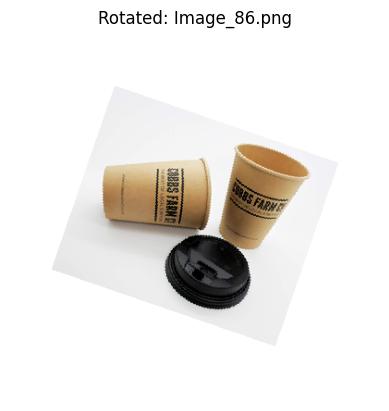

In [5]:
import random
from PIL import Image

# 隨機選一張 test_image_dir 的圖片，套用 rotate_and_pad_dynamic 並顯示
import matplotlib.pyplot as plt
dir = 'clean_dataset/paper_cup'
# 隨機選一張圖片
image_files = [f for f in os.listdir(dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
img_name = random.choice(image_files)
img_path = os.path.join(dir, img_name)
img = Image.open(img_path).convert('RGB')

# 套用 rotate_and_pad_dynamic
rotated_img = rotate_and_pad_dynamic(img, angle=random.randint(-30, 30))

# 顯示圖片
plt.imshow(rotated_img)
plt.title(f'Rotated: {img_name}')
plt.axis('off')
plt.show()

In [6]:
# Create the datasets and data loaders
transform = transforms.Compose([
    transforms.Lambda(lambda img: rotate_and_pad_dynamic(img, angle=random.randint(-60, 60))),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = WasteDataset(dataset_path, split='train', transform=transform)
val_dataset = WasteDataset(dataset_path, split='val', transform=transform)
test_dataset = WasteDataset(dataset_path, split='test', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Initialization

In [7]:
from torchvision import models, datasets, transforms
import torchvision
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Create the model, loss function, and optimizer
num_classes = len(train_dataset.classes)

model = models.resnet50(pretrained=True)    

# 凍結所有參數（如要 fine-tune 可改為 False）
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

c:\Users\awfan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\awfan\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training


In [8]:
# Lists to store the training and validation losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to('cuda')
        labels = labels.to('cuda')
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
    
    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("Training completed!")

Epoch [1/10], Train Loss: 1.2806, Val Loss: 0.9474
Epoch [2/10], Train Loss: 0.9031, Val Loss: 0.6818
Epoch [3/10], Train Loss: 0.6847, Val Loss: 0.6409
Epoch [4/10], Train Loss: 0.6117, Val Loss: 0.5053
Epoch [5/10], Train Loss: 0.5546, Val Loss: 0.4691
Epoch [6/10], Train Loss: 0.4781, Val Loss: 0.4112
Epoch [7/10], Train Loss: 0.4511, Val Loss: 0.3667
Epoch [8/10], Train Loss: 0.4136, Val Loss: 0.3585
Epoch [9/10], Train Loss: 0.4295, Val Loss: 0.3441
Epoch [10/10], Train Loss: 0.3768, Val Loss: 0.3799
Training completed!


In [9]:
torch.save(model, 'waste_classification_model_resnet_without_rotate.pth')
print("Model saved successfully!")

Model saved successfully!


# 載入並測試模型

In [10]:
device = 'cuda'
testmodel = torch.load('waste_classification_model_resnet.pth') 
testmodel.eval()  # 切換到評估模式
correct = 0
total = 0

with torch.no_grad():  # 評估時不計算梯度
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = testmodel(images)             # 前向推論，shape=(batch_size, num_classes)
        _, preds = torch.max(outputs, 1)    # 取每列最大值的索引作為預測

        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")


C:\Users\awfan\AppData\Local\Temp\ipykernel_30496\3442139262.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testmodel = torch.load('waste_classification_model_resnet.pt

Test Accuracy: 85.22%


In [11]:
import os
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms

# 建立反標準化的 transform（ImageNet mean/std）
unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

# 儲存處理過的圖片
def save_tensor_as_image(tensor, filename):
    img = unnormalize(tensor.squeeze(0)).clamp(0, 1)  # 去 batch 維 + 限定 0~1
    img_pil = to_pil_image(img)
    os.makedirs('rotated_image', exist_ok=True)
    img_pil.save(os.path.join('rotated_image', filename))


In [12]:
# train_dataset.classes

In [13]:
import os
from PIL import Image
import torch
from torchvision import transforms
from rembg import remove

# 設定測試圖片資料夾
test_image_dir = 'custom_test/'

# 模型輸入所需的轉換（依照你訓練時使用的 transform）
transform = transforms.Compose([
    transforms.Lambda(lambda img: rotate_and_pad_dynamic(img, angle=random.randint(-30, 30))),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 載入你訓練好的模型
testmodel = torch.load('waste_classification_model_resnet.pth')
testmodel.eval()
testmodel.to('cuda')
# 類別標籤（順序需與訓練時相符）
class_names = train_dataset.classes

# 預測每一張圖片
for filename in os.listdir(test_image_dir):
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        image_path = os.path.join(test_image_dir, filename)
        image = Image.open(image_path).convert('RGB')
        #image = remove(image).convert('RGB')
        
        input_tensor = transform(image).unsqueeze(0)  # 增加 batch dimension
        input_tensor = input_tensor.to('cuda')
        save_tensor_as_image(input_tensor, filename)  # 儲存處理過的圖片
        
        with torch.no_grad():
            output = testmodel(input_tensor)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            print(probabilities)
            predicted_class = class_names[output.argmax(1).item()]
        
        if predicted_class.startswith('aluminum_') or predicted_class.startswith('steel'):
            print(f"{filename} → 預測為: 鐵鋁罐")
        elif predicted_class.startswith('paper_meal'):
            print(f"{filename} → 預測為: 紙餐盒")
        elif predicted_class.startswith('plastic'):
            print(f"{filename} → 預測為: 寶特瓶")
        elif predicted_class.startswith('paper_c'):
            print(f"{filename} → 預測為: 紙杯")

C:\Users\awfan\AppData\Local\Temp\ipykernel_30496\660921875.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  testmodel = torch.load('waste_classification_model_resnet.pt

tensor([[0.0803, 0.6569, 0.2322, 0.0306]], device='cuda:0')
image2.png → 預測為: 紙餐盒
tensor([[0.0369, 0.0260, 0.9339, 0.0032]], device='cuda:0')
image3.png → 預測為: 紙杯
tensor([[0.0481, 0.0185, 0.0259, 0.9075]], device='cuda:0')
image4.png → 預測為: 寶特瓶
tensor([[0.6421, 0.0184, 0.3063, 0.0332]], device='cuda:0')
image5.png → 預測為: 鐵鋁罐
